# Process the data
Experiment with Aarhus (2020):
- 18 keV
- pixel = 6.5/40 um
- distances: 135, 140, 144, 152


**Comments**:
<br>
some problems with the data collection for distances 140 and 144 mm.
- In the case of 140mm, the images of section 79 were not recorded – this dataset includes one additional section (120) which was probably recorded to replace 79 but they are not at the same position. Section 79 is part of the sample while section 120 is outside of the sample. That is clear when using images 120 in the position of section 79.
- For 144mm, the images of section 55 were not recorded in between 201.8 and 360 degrees (except for 201.9). This is why I was getting an error when running the stitching function for some slices at distance 144mm – these slices only have 118 images, as opposed to 119.

In [3]:
import numpy as np
from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile
import matplotlib.pyplot as plt
import os

## Functions

In [18]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

cutme_from_both_sides = 100

image_size = 2048 - cutme_from_both_sides
crop_area = 2048 - int(motor_step_pix)

In [19]:
# select just one distance and one acquisition/projection
def find_paths_single_distance_all(data_list, key, distance, image):
    return [i for i in data_list if (i.startswith(key) and distance in i and image in i)]

In [20]:
# this is also very ugly way of sorting
def find_counter(string, start, end):
    return (string.split(start))[1].split(end)[0]

In [21]:
def find_ffs_simple(data_list, key):
    """
    Just for one image
    data_list: all data in the folder
    key: name of the file for which ff-s should be found
    """
    outs = [i for i in data_list if i.startswith('ff_'+key)]
    outs.sort()
    return outs

def find_ffs_list(data_list, image_list):
    """
    For a list of images
    data_list: all data in the folder
    image_list: list of images for which you want to find ff-s
    key: name of the file for which ff-s should be found
    """
    all_ff=[]
    for i in image_list:
        one_ff = []
        key = i[:-10]
        one_ff.append(find_ffs_simple(imlist, key))
        all_ff.append(one_ff)
        
    return all_ff

In [22]:
def ff_correct_one(image_path, ff_data, ROI=(cutme_from_both_sides, cutme_from_both_sides, 2048,2048)):    
    """
    This function takes 1 data image and ff corrects it
    
    image_data: str
        path to images
    ff_data: list
        paths to ff
    ROI: (line_start, row_start, line_finish, row_sinish)
        define the area for the ff-correction
        you need to avoid using 100 first rows as they contain logs for PCO images
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = tifffile.imread(folder+image_path)
    images = images[ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(images)
    ff_class = SSIM.SSIM_const(flatfield)

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result = np.asarray(images[:]/flatfield[:,:,np.argmax(index)])
    return result

In [76]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def find_shifts():
    pass

def stitchme_from_array(images, crop = np.s_[:,
                                             :int(motor_step_pix) - 50,
                                             :int(motor_step_pix) - 50]):
    
    # this part is questionable, the offset should be calculated better above (auto-shift function)
    # images = find_shifts(images)
    images = images[crop]
    
    outs = []
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))


def open_one_ff_stitch(distance = '135mm',
                   image = '00001.tiff',
                   key = 'try0'):
    
    # open images
    #print('### Started to open images for ', distance)
    data_test = find_paths_single_distance_all(imlist, key =key, distance = distance, image = image)
    data_test = sorted(data_test, key=lambda i: int(find_counter(i, start = distance + "_", end = "_"+image)))
    
    # open ff-s
    #print('### Started to open flatfields for ', distance)
    ff_test = find_ffs_list(imlist, image_list = data_test)
    
    # ff-correct
    #print('### Started ff-correction for ', distance)
    ff_corrected = []
    for counter,image in enumerate(data_test):
        ff_corrected.append(ff_correct_one(image, ff_test[0][0]))
    ff_corrected = np.asarray(ff_corrected)
    
    # shift and stitch
    #print('### Started stiching ', distance)
    result = stitchme_from_array(ff_corrected)
    
    # report on finishing and show results
    #plt.imshow(result, cmap = 'gray', vmax = 1)
    print('    Succesfully processed distance ', distance, 'image', image)
    
    return result

## Start execution 25.01.2022

In [65]:
folder_read = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'

# deposit projections in the array at the disk
path_to_save = '/mx-beta/anaconda3/mpolikarpov_scripts/2021_Aarhus/test_data/'
array_name = 'deleteme_please'

# shape of your array
shape = (3600,10416,25296)

In [ ]:
#create the list all images in the folder
imlist = os.listdir(folder_read)

# select proper endings
counts = [str(i).zfill(5)+'.tiff' for i in range(1,3601)]

In [75]:
# create array to store the data
f = np.memmap(path_to_save+array_name+'.npy', dtype = 'float64', mode = 'w+', shape=shape) 
del f

# process all data
for counter, value in enumerate(counts[:2]):
    
    print('### started processing ', value)
    # do something
    result = open_one_ff_stitch(distance = '135mm', image = value)
    #result = np.zeros((10416,25296), dtype = 'float64')
    
    # save
    f = np.memmap(path_to_save+array_name+'.npy', dtype = 'float64', mode = 'r+', shape=shape) 
    f[counter, :] = result
    del f

### started processing  00001.tiff
   Succesfully processed distance  135mm image try0_full_135mm_119_00001.tiff
### started processing  00002.tiff
   Succesfully processed distance  135mm image try0_full_135mm_119_00002.tiff


In [66]:
ls '/mx-beta/anaconda3/mpolikarpov_scripts/2021_Aarhus/test_data/'

deleteme_please  deleteme_please.npy  test_projection_135mm_0001.npy


In [71]:
# process one projection and save it
proj1_135 = open_one_ff_stitch(distance = '135mm', image = '00001.tiff')

Succesfully processed distance  135mm image try0_full_135mm_119_00001.tiff


## CONTINUE HERE AFTER -> Make Tomography

In [54]:
# load the data
#ff_corrected = np.load(path_to_save+'test_projection_135mm_0001.npy')
proj = np.memmap(path_to_save+array_name+'.npy', dtype = 'float64', mode = 'r', shape=shape)

In [ ]:
tomopy. 

### Open and ff-correct one projection

In [ ]:
whatever_list = 
path = 
filename = 'reconstruction_170122_test0'
shape = (N_proj, 3, ff[0].shape[1], ff[0].shape[2])



# create array to store the data
f = np.memmap(path+filename, dtype = 'float64', mode = 'w+', shape=shape) 
del f


for counter, value in enumerate(whatever_list):
    
    # process
    #process = open_one_ff_stitch(distance = '135mm', image = '00001.tiff')
    process = open_one_ff_stitch(distance = '135mm', image = value)
    
    # save 
    f = np.memmap(path+filename, dtype = 'float64', mode = 'r+', shape=shape) 
    f[counter, :] = reconstructme
    del f
    print('processed ', str(value))

## ADD-ON module: phase retrieval (in development)

In [458]:
testme = [proj1_135, proj1_152]

In [459]:
# calculate shift of the image between the i-th and the 1-st distance
from maximus48 import multiCTF2 as multiCTF

shift = []

for i in np.arange(len(testme)):
    shift.append(multiCTF.shift_distance(testme[0], testme[i], 100))

print(shift)

[array([0., 0.]), array([ 31.05, -84.35])]


In [533]:
shift[0]

array([0., 0.])

In [462]:
result = testme

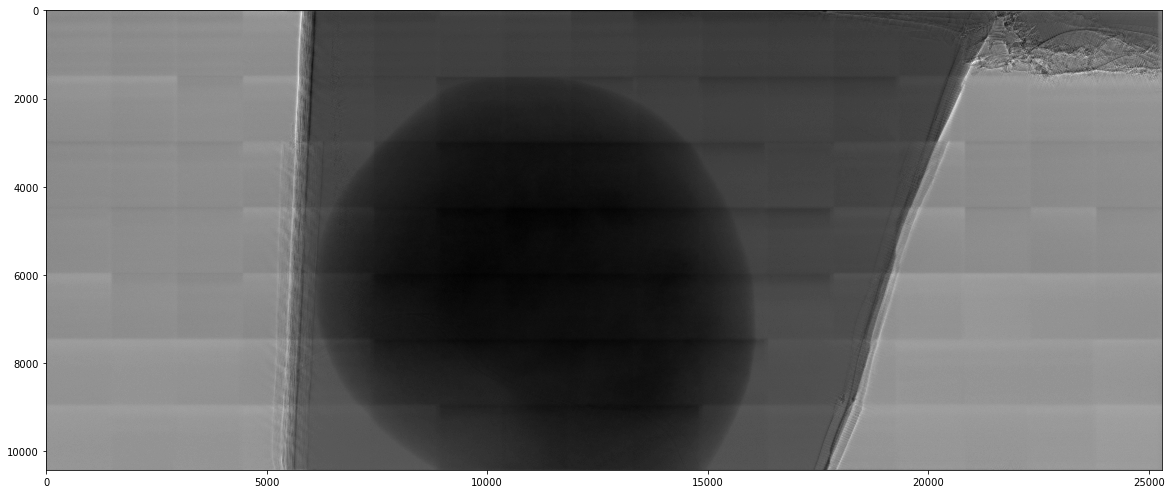

In [500]:
# Now, let's shift images 
out = multiCTF.shift_imageset(np.asarray(result), np.asarray(shift))
out = np.asarray(out)

# pixel size
pixel = 0.1625 * 1e-6                                                           

# distances 
distance = np.array((13.5,15.2), dtype = 'float32') * 1e-2                # distances of your measurements 
distance = np.array((20.3,22), dtype = 'float32') * 1e-2  

# photon energy
energy = 18   
wavelength = var.wavelen(energy)

# CTF parameters
beta_delta = 0.15
zero_compensation = 0.01


# Padding - in pixels for each side
#Npad = 200
#out = np.pad(out, ((0,0),(Npad, Npad),(Npad, Npad)), 'edge')  

# CTF-retrieval
fresnelN = pixel**2/(wavelength*distance)
final = multiCTF.multi_distance_CTF(out, beta_delta, fresnelN, zero_compensation)

# unpad images and show the result
#final = final[Npad:(final.shape[0]-Npad),Npad:(final.shape[1]-Npad)]                           
var.show(final)